In [1]:
from copyreg import remove_extension
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

from CSIKit.util import byteops
from CSIKit.reader import NEXBeamformReader
from CSIKit.tools.batch_graph import BatchGraph
from CSIKit.util.filters import hampel
from CSIKit.util.filters import running_mean
from CSIKit.util.filters import bandpass
from CSIKit.util import csitools
from sklearn import preprocessing

from matplotlib import cm
from matplotlib.ticker import LinearLocator
import draw
import copy

In [2]:
def wrap2pi(phases):
    phases = (phases + np.pi) % (2 * np.pi) - np.pi
    return phases

calib_step = 10 * 10 ** -9  # ns
freq_delta = 312.5 * 10 ** 3
max_slope = 50000 * 10 ** -9
min_slope = -max_slope

def remove_slope(phases, scidx_data, slope2remove: float = None):
    tmp_phases = phases
    steps = 0
    if slope2remove is None:
        slope = 0
        unwrap_phases = np.unwrap(tmp_phases)
        while abs(max(unwrap_phases) - min(unwrap_phases)) > np.pi and slope < max_slope:
            steps = steps + 1
            slope = slope + calib_step
            tmp_phases = wrap2pi(tmp_phases + 2 * np.pi * scidx_data * freq_delta * calib_step)
            unwrap_phases = np.unwrap(tmp_phases)
        if slope >= max_slope:
            tmp_phases = phases
            slope = 0
        unwrap_phases = np.unwrap(tmp_phases)
        p = np.polyfit(scidx_data, unwrap_phases, 1)
        slope = slope - p[0] / (2 * np.pi * freq_delta)
        tmp_phases = wrap2pi(tmp_phases - p[0] * scidx_data)
    else:
        slope = slope2remove
        tmp_phases = wrap2pi(tmp_phases + 2 * np.pi * scidx_data * freq_delta * slope)
    return tmp_phases


def normalization(x):
    x = (x - np.min(x)) / (np.max(x) - np.min(x))  # Normalization
    # x = x / np.max(x)
    return x

def covariance(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    return cov

def sort(list):
    l = len(list)
    for i in range(l-1,0,-1):
        for j in range(i):
            if list[j] > list[j+1]:
                list[j],list[j+1] = list[j+1],list[j]
    return list

def filter(b,a,x):
    y = []
    y.append(b[0] * x[0])
    for i in range(1,len(x)):
        y.append(0)
        for j in range(len(b)):
            if i >= j :
                y[i] = y[i] + b[j] * x[i - j ]
                j += 1
        for l in range(len(b)-1 ):
            if i >l:
                y[i] = (y[i] - a[l+1] * y[i -l-1])
                l += 1
        i += 1
    return y

def meanprocess(x):
    mean_value = np.mean(x)
    x_new = x - mean_value
    return x_new

def remove_fill(x,frame_no):
    # x_new = x.copy()
    x_new = pd.Series(x)
    for j in frame_no:
        value = x_new.values[j]
        x_new = x_new.replace(value,np.nan)
        x_new = x_new.interpolate()
        x_new_1 = x_new.to_numpy()
        x_new_1 = x_new_1.transpose()
    return x_new_1

# def remove_nan(x):
#     x_new = pd.Series(x)
#     x_new = x_new.replace([np.inf,-np.inf],np.nan)
#     x_new = x_new.interpolate()
#     x_new_1 = x_new.to_numpy()
#     x_new_1 = x_new_1.transpose()
#     return x_new_1

def remove_nan(x):
    x_new = pd.Series(x)
    x_new = x_new[~x_new.isin([np.nan, np.inf, -np.inf]).any(1)]

def heatmap3d(subcarrier_new,phase_error_output):
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.array(subcarrier_new)
    frame_no = []
    line_no = np.shape(phase_error_output)[0]
    for i in range(line_no):
        frame_no.append(i)
    Y = np.array(frame_no)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(phase_error_output) 

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False, vmin=-np.pi, vmax=np.pi)

    # Customize the z axis.
    ax.set_zlim(-np.pi, np.pi)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    # ax.zaxis.set_major_formatter('{x:.00f}')

    # Add a color bar which maps values to colors.
    cbar_ax = fig.add_axes([0.84, 0.2, 0.03, 0.55])
    fig.colorbar(surf,cbar_ax)

    plt.savefig('/Users/liangxintai/Desktop/1.png',dpi=300)

    plt.show()


In [6]:
my_reader = NEXBeamformReader()
csi_files = [ 
                # "iphone12pro_lab_s1.pcap",
                # "ipadair4_lab_s1.pcap",
                # "ipad7_lab_s1.pcap",
                # "spoofer_lab_s1.pcap",

                "iphone12pro_lab_s2.pcap",
                # "ipadair4_lab_s2.pcap"
                # "ipad7_lab_s2.pcap",
                # "spoofer_lab_s1.pcap",

                # "iphone12pro_lab_s3.pcap",
                # "ipadair4_lab_s3.pcap"
                # "ipad7_lab_s3.pcap",
                # "spoofer_lab_s1.pcap",

                # "iphone12pro_lab_s4.pcap",
                # "ipadair4_lab_s4.pcap"
                # "ipad7_lab_s4.pcap",
                # "spoofer_lab_s1.pcap",

                # "iphone12pro_home_s1.pcap",
                # "ipadair4_home_s1.pcap",
                # "ipad7_home_s1.pcap",
                # "spoofer_home_s1.pcap",

                # "iphone12pro_home_s2.pcap",
                # "ipadair4_home_s2.pcap",
                # "ipad7_home_s2.pcap",
                # "spoofer_home_s2.pcap",

                # "iphone12pro_lab_s1_moving.pcap",
                # "ipadair4_lab_s1_moving.pcap",
                # "ipad7_lab_s1_moving.pcap",
                # "spoofer_lab_s1_moving.pcap"

                # "iphone12pro_lab_s1_moving_test.pcap",
                # "ipadair4_lab_s1_moving_test.pcap",
                # "ipad7_lab_s1_moving_test.pcap",
                # "spoofer_lab_s1_moving_test.pcap",

                
                # "test.pcap",
                # "test_6.pcap",

                # "two_user.pcap",
                # "user_moving.pcap",
                # "only_user_moving.pcap"

                # "user_mobile.pcap",
                # "user_mobile_s1.pcap",
                # "user_spoofer_mobile_s1.pcap"

                # "client_profile.pcap"

               ]
for csi_file in csi_files:
    # csi_data = my_reader.read_file("/home/hongyu/Development/csi_data/" + csi_file)
    csi_data = my_reader.read_file("/Users/liangxintai/Desktop/nexmon_csi-master/utils/matlab/" + csi_file)
    # csi_data = my_reader.read_file("/home/hongyu/Downloads/output_80_office.pcap")
    # csi_data = my_reader.read_file("/home/hongyu/Development/CSIKit/CSIKit/data/nexmon/example_4366c0_4x4mimo.pcap")

csi = csi_data.frames[0].csi_matrix   # Remove frame from data
sc_count = np.shape(csi)[0]
sc_idx = np.arange(sc_count) - int(sc_count / 2)     # generate index for subcarriers
sc_count_new = sc_count - 36
sc_idx_new = np.arange(sc_count_new) - int(sc_count_new/2)
scidx_80mhz_csi_no_dc = [-1,0,1]
no_dc = [x+128 for x in scidx_80mhz_csi_no_dc]
scidx_80mhz_csi_no_pilot = [-103, -75, -39, -11, 11, 39, 75, 103]
no_pilot = [x+128 for x in scidx_80mhz_csi_no_pilot]
gen_scidx_data_80mhz_csi = np.in1d(sc_idx, scidx_80mhz_csi_no_pilot)
# print(gen_scidx_data_80mhz_csi)
stream_count = np.shape(csi)[1]  # TX antenna
ant_count = np.shape(csi)[2]  # RX antenna

In [217]:
#################Timestamp####################
timestamp = csi_data.timestamps
timestamp = np.array([timestamp])
print(np.shape(timestamp))
# print(np.shape(csi))

(1, 3977)


In [7]:
#############Phase Extraction####################

csi_phase, no_frames, no_subcarriers = csitools.get_CSI(csi_data, metric="phase")
csi_phase_subch  = csi_phase[:,:,0,1]
csi_phase_subch_org = csi_phase_subch.copy()

for i in range(no_frames):
    csi_phase_subch[i,:] = remove_fill(csi_phase_subch[i,:],no_pilot)
    for j in range(6):
        # csi_phase_subch[i,:] = remove_fill(csi_phase_subch[i,:],no_pilot)
        csi_phase_subch[i,:] = remove_fill(csi_phase_subch[i,:],no_dc)

    
# csi_phase = csitools.get_CSI(csi_data, metric="phase")[0]
# csi_original_subch1 = csi_original[:,:,0,0]
# csi_original_subch2 = csi_original[:,:,0,1]
# csi_original_relative = np.zeros((no_frames,no_subcarriers), dtype="complex")

# for i in range(no_subcarriers):
#     csi_original_relative[:,i] = csi_original_subch1[:,i] * csi_original_subch2[:,i]

# print(csi_original_relative)

# csi_amplitude_buff = np.zeros(np.shape(csi_amplitude_subch))
# csi_phase_relative_org = np.angle(csi_original_relative)
csi_phase_buff = np.zeros((no_frames,220))
csi_phase_grad = np.zeros((no_frames,220))
# # csi_phase_wrapped = wrap2pi(csi_relative_phase)

for i in range(no_frames):
    csi_phase_buff[i,:] = np.unwrap(csi_phase_subch[i,17:237])
    csi_phase_grad[i,:] = np.gradient(csi_phase_buff[i,:])

csi_phase_calib = csi_phase_buff.copy()

for i in range(no_frames):
    csi_phase_calib[i,47:] = csi_phase_calib[i,47:] - np.pi
    # csi_phase_calib[i,129:] = csi_phase_calib[i,129:] - np.pi

csi_phase_want = csi_phase_calib.copy()

scoretable_phase_grad_std = np.zeros((no_frames,1))

for i in range(no_frames):
    std_score = 0
    std_score = np.std(csi_phase_grad[i,:])
    scoretable_phase_grad_std[i,:] = std_score

scoretable_phase_grad_std_sorted = np.argsort(scoretable_phase_grad_std, axis=0)
# frame_phase_std_selected = scoretable_phase_grad_std_sorted[3:8,:]

csi_phase_normalized = csi_phase_buff.copy()
# csi_phase_smooth = csi_phase_buff.copy()

nan = np.where(np.isnan(csi_phase_calib))
nan_line = nan[0]
nan_list = nan_line.tolist()

result = [] 
for i in nan_list: 
    if i not in result: 
        result.append(i) 

# print(result)

for i in result:
    csi_phase_calib[i,:] = csi_phase_calib[i-1,:]


for i in range(no_frames):
    
    # csi_phase_normalized[i,:] = normalization([csi_phase_calib[i,:]])
    # csi_phase_normalized[i,:] -= np.mean(csi_phase_normalized[i,:], axis=0)
    # center_phase = (csi_phase_calib[i,109] + csi_phase_calib[i,110])/2
    # csi_phase_normalized[i,:] = csi_phase_calib[i,:] - center_phase
    csi_phase_normalized[i,:] = meanprocess(csi_phase_calib[i,:])
    # csi_phase_normalized[i,:] = preprocessing.normalize([csi_phase_normalized[i,:]])


# csi_phase_smooth = csi_phase_normalized[:,18:238].copy()

scoretable_phase_cov = np.empty((no_frames,1))


/opt/homebrew/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


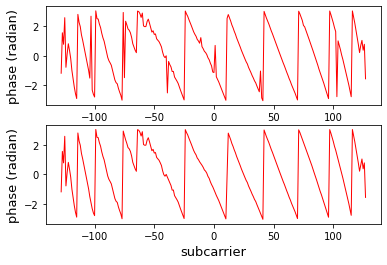

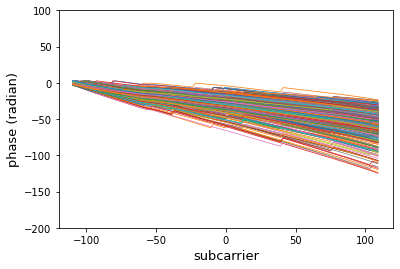

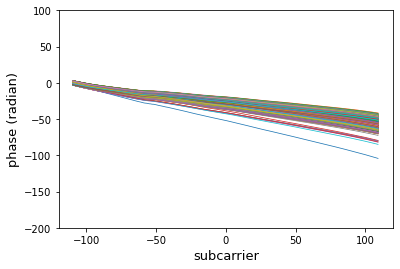

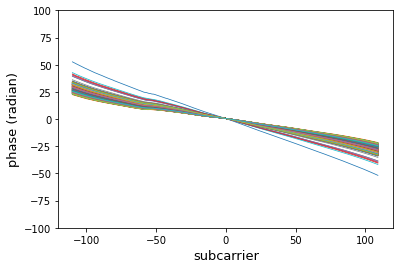

500


In [8]:
frame_phase_selected_final = []
csi_phase_freq_output = []
csi_phase_smooth_final = []
csi_phase_calib_output = []
frame_phase_std_selected = scoretable_phase_grad_std_sorted[25:525,:]
# frame_phase_selected = scoretable_phase_sorted[3:1100,:]

frame = []
for x in range(no_frames):
    frame.append(x)
        
subcarrier = []
for x in range(min(sc_idx),max(sc_idx)+1):
    subcarrier.append(x)

subcarrier_data = []
for x in range(min(sc_idx_new),max(sc_idx_new)+1):
    subcarrier_data.append(x)

no = 26
for i in range(no,no+1):
    plt.subplot(211)
    plt.plot(subcarrier, csi_phase_subch_org[i,:],'r',linewidth=1)
    plt.ylabel('phase (radian)', fontsize = 13)
    plt.subplot(212)
    plt.plot(subcarrier, csi_phase_subch[i,:],'r',linewidth=1)
    plt.ylabel('phase (radian)', fontsize = 13)
    plt.xlabel('subcarrier',fontsize = 13)
plt.savefig('Ph_inter.png',dpi=1000)
plt.show()

# for i in range(0,1):
#     plt.plot(subcarrier, csi_phase_subch_org[i,:], linewidth=0.75)
# plt.show()

for i in range(no_frames):
    # csi_phase_freq = csi_phase_calib[i,:]
    plt.plot(subcarrier_data, csi_phase_want[i,:], linewidth=0.75)
plt.ylim((-200,100))
plt.xlim((-120,120))
plt.ylabel('phase (radian)', fontsize = 13)
plt.xlabel('subcarrier',fontsize = 13)
plt.savefig('ph1.png',dpi=1000)
plt.show()

for i in range(no_frames):
    if i in frame_phase_std_selected:
        plt.plot(subcarrier_data,csi_phase_calib[i,:], linewidth=0.75)
        csi_phase_calib_output.append(csi_phase_calib[i,:])
plt.ylim((-200,100))
plt.xlim((-120,120))
plt.ylabel('phase (radian)', fontsize = 13)
plt.xlabel('subcarrier',fontsize = 13)
plt.savefig('ph2.png',dpi=1000)
plt.show()

for i in range(no_frames):
    if i in frame_phase_std_selected:
        frame_phase_selected_final.append(i)
        csi_phase_smooth_final.append(csi_phase_normalized[i,:])
        # plt.subplot(211)
        plt.plot(subcarrier_data,csi_phase_normalized[i,:], linewidth=0.75)
# plt.ylim((-0.6,0.6))
plt.ylim((-100,100))
plt.xlim((-120,120))
plt.ylabel('phase (radian)', fontsize = 13)
plt.xlabel('subcarrier',fontsize = 13)
plt.savefig('ph3.png',dpi=1000)
plt.show()

# for i in range(no_frames):
#     if i in frame_phase_std_selected:
#         plt.subplot(212)
#         plt.plot(subcarrier_data,csi_phase_smooth[i,:], linewidth=0.75)
#         csi_phase_smooth_final.append(csi_phase_smooth[i,:])        
# # plt.ylim((-0.6,0.6))
# plt.xlim((-135,135))
# plt.show()

print(np.shape(csi_phase_smooth_final)[0])

In [7]:
print(np.shape(csi_phase_smooth_final))

(500, 220)


In [15]:
csi_phase_smooth_final = np.array(csi_phase_smooth_final)
csi_phi = csi_phase_smooth_final.copy()

# csi_phi = csi_phi[:,82:138]

lamda = []
phase_error = np.zeros(np.shape(csi_phi))
frame_need = 500

for i in range(frame_need):
    z = (csi_phi[i,109]+csi_phi[i,110])/2
    # z = 0
    phi1 = csi_phi[i,0]-z
    phi2 = csi_phi[i,219]-z
    lamda1 = phi1 / (2*np.pi*-110)
    lamda2 = phi2 / (2*np.pi*110)
    lamda = (lamda1+lamda2)/2
    
    for j in range(220):
        phase_error[i,j] = (csi_phi[i,j]-(2*np.pi*lamda*(j-110)+z))

# for i in range(frame_need):
#     z = (csi_phi[i,27]+csi_phi[i,28])/2
#     # z = 0
#     phi1 = csi_phi[i,0]-z
#     phi2 = csi_phi[i,55]-z
#     lamda1 = phi1 / (2*np.pi*-28)
#     lamda2 = phi2 / (2*np.pi*28)
#     lamda = (lamda1+lamda2)/2
    
    # for j in range(56):
    #     phase_error[i,j] = (csi_phi[i,j]-(2*np.pi*lamda*(j-28)+z))

# phase_error = csi_phase_smooth_final.copy()

phase_error_org = copy.deepcopy(phase_error)

# phase_error = copy.deepcopy(phase_error_new)

for i in range(np.shape(phase_error)[0]):
    # phase_error[i,:] = hampel(phase_error[i,:],3,1)
    phase_error[i,:] = running_mean(phase_error[i,:],10)
    phase_error[i,:] = meanprocess(phase_error[i,:])
    # phase_error[i,:] = preprocessing.normalize([phase_error[i,:]])
    # phase_error[i,:] = preprocessing.normalize([phase_error[i,:]])

# phase_error = phase_error[:,6:248].copy()

<function matplotlib.pyplot.show(close=None, block=None)>

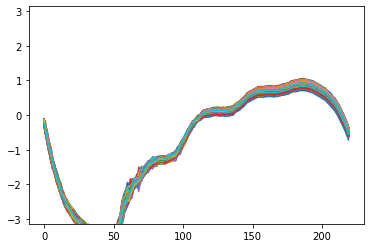

In [16]:
x,y = np.shape(phase_error)
# phase_error_output = []

subcarrier_new = []
for m in range(y):
    subcarrier_new.append(m)

for i in range(frame_need):
    # plt.plot(subcarrier_data,phase_error_org[i,:])
    plt.plot(phase_error_org[i,:])
    # phase_error_output.append(phase_error[i,:])
plt.ylim((-np.pi,np.pi))
plt.show

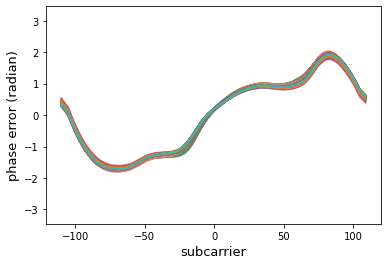

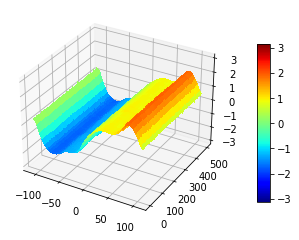

In [127]:
x,y = np.shape(phase_error)
phase_error_output = []
        
subcarrier_new = []
for m in range(y):
    subcarrier_new.append(m)

for i in range(frame_need):
    plt.plot(subcarrier_data,phase_error[i,:])
    phase_error_output.append(phase_error[i,:])
plt.ylabel('phase error (radian)', fontsize = 13)
plt.xlabel('subcarrier', fontsize = 13)
plt.ylim((-np.pi*1.1,np.pi*1.1))
plt.savefig('ph4.png',dpi=1000)
plt.show

for csi_file in csi_files:
    if csi_file == "iphone12pro_lab_s1.pcap":
        phase_error_1 = phase_error_output
        phase_error_1 = np.array(phase_error_1)
    elif csi_file == "ipadair4_lab_s1.pcap":
        phase_error_2 = phase_error_output
        phase_error_2 = np.array(phase_error_2)
    elif csi_file == "ipad7_lab_s1.pcap":
        phase_error_3 = phase_error_output
        phase_error_3 = np.array(phase_error_3)
    # elif csi_file == "spoofer_lab_s2.pcap":
    #     phase_error_4 = phase_error_output
    #     phase_error_4 = np.array(phase_error_4)
    elif csi_file == "iphone12pro_lab_s1_moving.pcap":
        phase_error_m1 = phase_error_output
        phase_error_m1 = np.array(phase_error_m1)
    elif csi_file == "ipadair4_lab_s1_moving.pcap":
        phase_error_m2 = phase_error_output
        phase_error_m2 = np.array(phase_error_m2)
    elif csi_file == "ipad7_lab_s1_moving.pcap":
        phase_error_m3 = phase_error_output
        phase_error_m3 = np.array(phase_error_m3)
    elif csi_file == "spoofer_lab_s1_moving.pcap":
        phase_error_m4 = phase_error_output
        phase_error_m4 = np.array(phase_error_m4)
    elif csi_file == "iphone12pro_lab_s1_moving_test.pcap":
        phase_error_mt1 = phase_error_output
        phase_error_mt1 = np.array(phase_error_mt1)
    elif csi_file == "ipadair4_lab_s1_moving_test.pcap":
        phase_error_mt2 = phase_error_output
        phase_error_mt2 = np.array(phase_error_mt2)
    elif csi_file == "ipad7_lab_s1_moving_test.pcap":
        phase_error_mt3 = phase_error_output
        phase_error_mt3 = np.array(phase_error_mt3)
    


heatmap3d(subcarrier_data, phase_error_output)

In [14]:
print(np.shape(phase_error_output))

(500, 220)


In [133]:
index_name = ['404' for _ in range(1000)]
csi_phase_data=pd.DataFrame(data=phase_error_output,index=index_name)
csi_phase_data.to_csv('/Users/liangxintai/Desktop/CSI_authentication/multi_spoofer/spoofer_6user.csv',header=False)
# csi_phase_data.to_csv('/Users/liangxintai/Desktop/CSI_authentication/home_s2/data_sample/final_User_profile_phase/User1.csv',header=False)

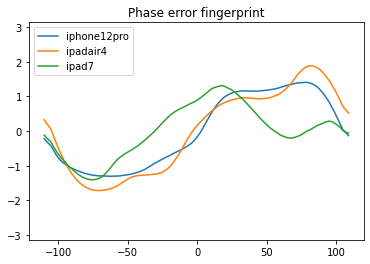

In [26]:
for i in range(2,3):
    plt.plot(subcarrier_data,phase_error_1[i,:], label='iphone12pro')
    plt.plot(subcarrier_data,phase_error_2[i,:], label='ipadair4')
    plt.plot(subcarrier_data,phase_error_3[i,:], label='ipad7')
    # plt.plot(subcarrier_new,phase_error_4[i,:], label='unknown spoofer')
plt.ylim((-np.pi,np.pi))
plt.legend()
plt.title('Phase error fingerprint')
plt.show()

In [1]:
# plot heatmaps

phase_error_plot = [phase_error_1, phase_error_2, phase_error_3]
i = 0

fig, axes = plt.subplots(nrows=3, ncols=1)

name = ['iphone12pro', 'ipadair4', 'ipad7']
# y_label = ['-128','128']
# y_pos = np.arange(len(y_label))

for ax in axes.flat:
# for i in range(3):
    ax.set_title(name[i])
    ax.set_ylabel('subcarriers')
    
    # ax.set_yticks(np.arange(-110,111,220))
    im = ax.imshow(np.transpose(phase_error_plot[i]), cmap='jet' ,aspect='0.25',vmin=-np.pi,vmax=np.pi)
    
    ax.invert_yaxis()
    ax.set_yticks([15,107,200])
    ax.set_yticklabels(["-110","0","110"])
    i = i+1
    if i == 3:
        ax.set_xlabel('no_frame',fontsize = 12)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.175, 0.03, 0.65])
fig.colorbar(im,cax=cbar_ax) 
fig.savefig('heatmap0.png', dpi=1000)
# plt.xlabel('no_frame')
# plt.legend()
plt.show()


input_path = '/Users/liangxintai/Desktop/CSI_authentication/diff_loc/'

files = os.listdir(input_path)
# print(files)

i = 0
name = ['iphone12pro', 'ipadair4', 'ipad7']
# df = pd.read_csv(input_path + files[0], header = None )
# data = np.array(df.iloc[:,1:])
# print(np.shape(data))

fig, axes = plt.subplots(nrows=3, ncols=1)

for ax in axes.flat:

    df = pd.read_csv(input_path + files[i], header = None )
    data = np.array(df.iloc[:,1:])
    ax.set_title(name[i])
    ax.set_ylabel('subcarriers')
    
    # ax.set_yticks(np.arange(-110,111,220))
    im = ax.imshow(np.transpose(data), cmap='jet' ,aspect='0.45',vmin=-np.pi,vmax=np.pi)
    
    ax.invert_yaxis()
    ax.set_yticks([15,107,200])
    ax.set_yticklabels(["-110","0","110"])

    ax.set_xticklabels('')
    ax.set_xticks([])
    ax.set_xticks([125,375,625,875],minor=True)
    ax.set_xticklabels(['L1','L2','L3','L4'],minor=True)
    i = i+1
    if i == 3:
        ax.set_xlabel('different locations',fontsize = 12)
    
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.175, 0.03, 0.65])
fig.colorbar(im,cax=cbar_ax) 
fig.savefig('heatmap1.png', dpi=1000)
# plt.xlabel('no_frame')
# plt.legend()
plt.show()



NameError: name 'phase_error_1' is not defined

In [130]:
########Amplitude Extraction###############

csi_amplitude, no_frames, no_subcarriers = csitools.get_CSI(csi_data, metric="amplitude")
# all_sub =  stream_count * ant_count * no_subcarriers
csi_amplitude_subch_buff = np.empty((no_frames, no_subcarriers))

i = 0

# for t in range(0,1):
#     for r in range(0,2):
#         csi_amplitude_subch = csi_amplitude[:,:,t,r]    # [:,:,(0,1),(0,3)] 2 TX antenna & 4 RX antenna
#         csi_amplitude_subch_buff[:,(256*i):(256*i+256)] = csi_amplitude_subch
#         i = i+1

csi_amplitude_subch = csi_amplitude[:,:,0,0]    # [:,:,(0,1),(0,3)] 2 TX antenna & 4 RX antenna

# csi_amplitude_subch1 = csi_amplitude[:,:,0,0]
# csi_amplitude_subch2 = csi_amplitude[:,:,0,1]
# csi_amplitude_subch_buff = np.hstack((csi_amplitude_subch1, csi_amplitude_subch2))
    
csi_amplitude_buff = np.zeros(np.shape(csi_amplitude_subch))

for i in range(no_frames):
    csi_amplitude_buff[i,:] = remove_fill(csi_amplitude_subch[i,:],no_pilot)
    for j in range(6):
        # csi_phase_subch[i,:] = remove_fill(csi_phase_subch[i,:],no_pilot)
        csi_amplitude_buff[i,:] = remove_fill(csi_amplitude_buff[i,:],no_dc)

for i in range(no_frames):
    # csi_amplitude_buff[i,:] = hampel(csi_amplitude_subch[i,:],10,1)
    # csi_amplitude_buff[i,:] = hampel(csi_amplitude_buff[i,:],20,3)
    csi_amplitude_buff[i,:] = running_mean(csi_amplitude_buff[i,:],10)
    # csi_amplitude_buff[i,:] = MinMaxNormalization(csi_amplitude_buff[i,:])

csi_amplitude_time = csi_amplitude_buff.copy()
        

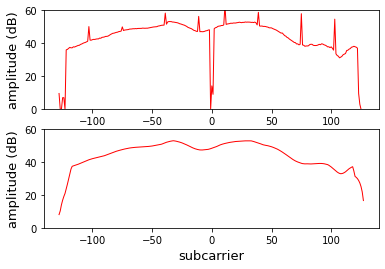

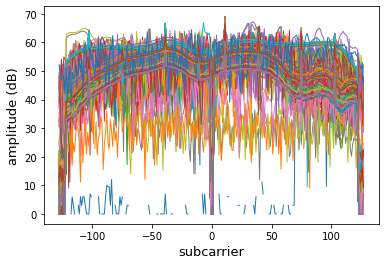

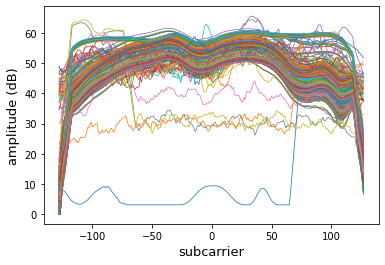

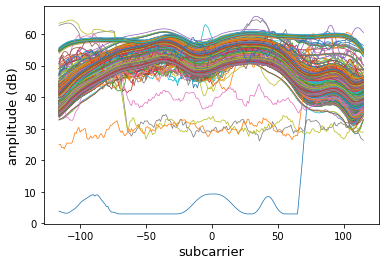

In [136]:
frame = []
for x in range(no_frames):
    frame.append(x)
        
subcarrier = []
for x in range(min(sc_idx),max(sc_idx)+1):
    subcarrier.append(x)

subcarrier_amplitude_new = []
for x in range(-116,116):
    subcarrier_amplitude_new.append(x)

# no_sub=[]
# all_sub = int(all_sub/4)

# for x in range(all_sub):
#     no_sub.append(x)

for i in range(30,31):
    plt.subplot(211)
    plt.plot(subcarrier, csi_amplitude_subch[i,:],'r', linewidth=1)
    plt.ylim(0,60)
    plt.ylabel('amplitude (dB)',fontsize =13)
    plt.subplot(212)
    plt.plot(subcarrier, csi_amplitude_buff[i,:],'r', linewidth=1)
    plt.ylim(0,60)
    plt.ylabel('amplitude (dB)',fontsize =13)
    plt.xlabel('subcarrier',fontsize =13)
plt.savefig('Amp_inter.png', dpi=1000)
plt.show()

for i in range(no_frames):                         # Amplitude_frequency plot 
    # plt.plot(subcarrier, csi_amplitude_org)
    mid = csi_amplitude_subch[i,:]
    plt.plot(subcarrier, mid, linewidth=1)
plt.ylabel('amplitude (dB)',fontsize =13)
plt.xlabel('subcarrier',fontsize =13)
plt.show()

for i in range(no_frames):                         # Amplitude_frequency plot 
    # plt.plot(subcarrier, csi_amplitude_org)
    mid = csi_amplitude_buff[i,:]
    plt.plot(subcarrier, mid, linewidth=0.75)
plt.ylabel('amplitude (dB)',fontsize =13)
plt.xlabel('subcarrier',fontsize =13)
plt.show()

for i in range(no_frames):                         # Amplitude_frequency plot 
    # plt.plot(subcarrier, csi_amplitude_org)
    mid = csi_amplitude_buff[i,:]
    plt.plot(subcarrier_amplitude_new, mid[12:244],linewidth=0.75)
    # plt
plt.ylabel('amplitude (dB)',fontsize =13)
plt.xlabel('subcarrier',fontsize =13)
plt.savefig('amp1.png',dpi=1000)
plt.show()

csi_amplitude_freq = csi_amplitude_buff[:,12:244].copy()

# for j in range(no_subcarriers):                    # Amplitude_time plot
#     # csi_amplitude_time = csi_amplitude_buff[:,j]
#     plt.plot(frame,csi_amplitude_time[:,j], linewidth=0.75)
# plt.show()
# plt.show

In [70]:
print(np.shape(csi_amplitude_freq))
csi_amplitude_stamp = np.concatenate((timestamp.T, csi_amplitude_freq),axis = 1)
print(np.shape(csi_amplitude_stamp))

(3959, 232)
(3959, 233)


In [132]:
# scoretable_time = np.empty((1,no_subcarriers))
scoretable_freq = np.empty((no_frames,1))
scoretable_freq_std = np.empty((no_frames,1))
csi_amplitude_grad = np.empty((no_frames,220))

# for i in range(all_sub):
#     score = 0
#     x = csi_amplitude_time[:,i]
#     for j in range(all_sub):
#         y = csi_amplitude_time[:,j]
#         cov = covariance(x,y)
#         score = score + cov
#     scoretable_time[:,i] = score

for i in range(no_frames):
    csi_amplitude_grad[i,:] = np.gradient(csi_amplitude_buff[i,17:237])

scoretable_amplitude_grad_std = np.zeros((no_frames,1))

for i in range(no_frames):
    std_score = 0
    std_score = np.std(csi_amplitude_grad[i,:])
    scoretable_amplitude_grad_std[i,:] = std_score

scoretable_amplitude_grad_std_sorted = np.argsort(scoretable_amplitude_grad_std, axis=0)

# for i in range(no_frames):
#     score = 0
#     x = csi_amplitude_time[i,:]
#     for j in range(no_frames):
#         y = csi_amplitude_time[j,:]
#         cov = covariance(x,y)
#         score = score + cov
#     scoretable_freq[i,:] = score

# for i in range(no_frames):
#     std_score = 0
#     std_score = np.std(csi_amplitude_time[i,:])
#     scoretable_freq_std[i,:] = std_score

        

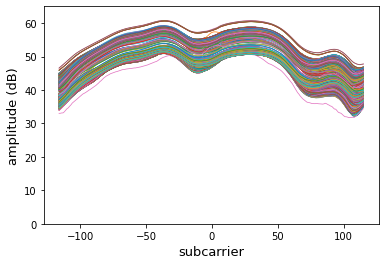

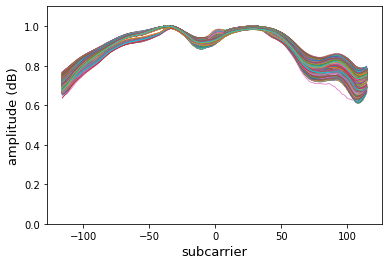

(1600,)
(1600, 232)


In [135]:
frame_amplitude_std_selected = scoretable_amplitude_grad_std_sorted[100:1700,:]

# scoretable_time_sorted = np.argsort(-1 * scoretable_time)
# sc_selected = scoretable_time_sorted[:,0:50]

scoretable_freq_sorted = np.argsort(-1 * scoretable_freq, axis=0)
# frame_selected = []
frame_selected = scoretable_freq_sorted[0:1700,:]

scoretable_freq_std_sorted = np.argsort(scoretable_freq_std, axis=0)
# frame_std_selected = []
frame_std_selected = scoretable_freq_std_sorted[0:1850,:]
frame_selected_final = []

csi_amplitude_freq_normalized = np.empty((no_frames,np.shape(csi_amplitude_freq)[1]))

#################################################################

nan = np.where(np.isnan(csi_amplitude_freq))
nan_line = nan[0]
nan_list = nan_line.tolist()

result = [] 
for i in nan_list: 
    if i not in result: 
        result.append(i) 

# print(result)

for i in result:
    csi_amplitude_freq[i,:] = csi_amplitude_freq[i+1,:]

nan = np.where(np.isnan(csi_amplitude_freq))
nan_line = nan[0]
nan_list = nan_line.tolist()

result = [] 
for i in nan_list: 
    if i not in result: 
        result.append(i) 

# print(result)

for i in result:
    csi_amplitude_freq[i,:] = csi_amplitude_freq[i+1,:]

#################################################################

csi_amplitude_freq_unnormalized = csi_amplitude_freq.copy()

for i in range(no_frames):
    csi_amplitude_freq_normalized[i,:] = preprocessing.normalize([csi_amplitude_freq[i,:]],norm='max')


csi_amplitude_freq_output = []
csi_amplitude_time_output = []

for i in range(no_frames):
    # if i in frame_selected and i in frame_std_selected:
    if i in frame_amplitude_std_selected:
        plt.plot(subcarrier_amplitude_new,csi_amplitude_freq_unnormalized[i,:], linewidth=0.75)
plt.ylim((0,65))
plt.ylabel('amplitude (dB)',fontsize =13)
plt.xlabel('subcarrier',fontsize =13)
plt.savefig('amp2.png',dpi=1000)
plt.show()

for i in range(no_frames):
    # if i in frame_selected and i in frame_std_selected:
    if i in frame_amplitude_std_selected:
        frame_selected_final.append(i)
        csi_amplitude_freq_output.append(csi_amplitude_freq_normalized[i,:])
        plt.plot(subcarrier_amplitude_new,csi_amplitude_freq_normalized[i,:], linewidth=0.75)
plt.ylim((0,1.1))
plt.ylabel('amplitude (dB)',fontsize =13)
plt.xlabel('subcarrier',fontsize =13)
plt.savefig('amp3.pdf', dpi=1000)
plt.show()

# for j in range(no_subcarriers):
#     if j in sc_selected:
#         csi_amplitude_time_output.append(csi_amplitude_time[:,j])
#         plt.plot(frame,csi_amplitude_time[:,j], linewidth=0.75)
# plt.ylim((0,1.1))
# plt.show()

print(np.shape(frame_selected_final))
print(np.shape(csi_amplitude_freq_output))
# print(np.shape(csi_amplitude_time_output))

for csi_file in csi_files:
    if csi_file == "iphone12pro_lab_s4.pcap":
        amplitude_1 = csi_amplitude_freq_output
        amplitude_1 = np.array(amplitude_1)
    elif csi_file == "ipadair4_lab_s4.pcap":
        amplitude_2 = csi_amplitude_freq_output
        amplitude_2 = np.array(amplitude_2)
    elif csi_file == "ipad7_lab_s4.pcap":
        amplitude_3 = csi_amplitude_freq_output
        amplitude_3 = np.array(amplitude_3)


In [220]:
index_name = ['0' for _ in range(1700)]
csi_phase_data=pd.DataFrame(data=csi_amplitude_freq_output,index=index_name)
csi_phase_data.to_csv('/Users/liangxintai/Desktop/CSI_authentication/multi_spoofer/amplitude/spoofer_6user_amplitude.csv',header=False)

In [73]:
# print(frame_amplitude_std_selected)
csi_amplitude_stamp_slected = []
# print(np.shape(csi_amplitude_stamp_slected))

for i in range(no_frames):
    if i in frame_amplitude_std_selected:
        csi_amplitude_stamp_slected.append(csi_amplitude_stamp[i,:])

csi_amplitude_stamp_slected = np.array(csi_amplitude_stamp_slected)

csi_amplitude_stamp_slected_sorted = csi_amplitude_stamp_slected[np.argsort(csi_amplitude_stamp_slected[:, 0])]

csi_amplitude_data=pd.DataFrame(data=csi_amplitude_stamp_slected_sorted, index=None)
csi_amplitude_data.to_csv('/Users/liangxintai/Desktop/CSI_authentication/mobile_detection/user_mobile_s1.csv',header=False, index=False)

In [47]:
for i in range(2,3):
    plt.plot(subcarrier_amplitude_new,'r',amplitude_1[i,:], label='iphone12pro')
    plt.plot(subcarrier_amplitude_new,'y',amplitude_2[i,:], label='ipadair4')
    plt.plot(subcarrier_amplitude_new,'b',amplitude_3[i,:], label='ipad7')
    # plt.plot(subcarrier_new,phase_error_4[i,:], label='unknown spoofer')
plt.ylim((0,1.05))
plt.legend()
plt.title('Amplitude fingerprint')
plt.show()

NameError: name 'amplitude_1' is not defined